# An Example of using `minimod`

For this notebook, we will first create the data needs to be used for the program. Then we will instantiate the class and make a report of the results using the `report` method

In [20]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%autoreload 2
import sys
import pandas as pd

import minimod as mm


In [4]:
## Data

# This is how the data was processed, assuming we use the Katie_VA_Benefits_and_Costs_1_8_2019.xlsx file.

## First we get a path to the raw data
excel_file = "data/raw/Katie_VA_Benefits_and_Costs_1_8_2019.xlsx"


# Get "vasoilold" and get discounted benefits for constraint

discount_costs = 1/(1 + 0.03)


vasoilold_constraint = (
    pd.read_excel(excel_file,
                  sheet_name = 'Benefits',
                  header = 2)
    .loc[lambda df : df['intervention'] == 'vasoilold']
    .set_index(['intervention', 'space'])
    .stack()
    .to_frame()
    .reset_index()
    .rename({
        'level_2' : 'time',
        0 : 'benefit'
    }, axis= 'columns')
    .assign(
        time_rank = lambda df: (df['time'].rank(numeric_only=True, method= 'dense') -1).astype(int) ,
        time_discount_costs = lambda df: discount_costs**df['time_rank'],
        discounted_benefits = lambda df: df['time_discount_costs']*df['benefit']
    )
    ['discounted_benefits'].sum()
    
)


In [59]:
df_benefit = (pd.read_excel(excel_file, 
                           sheet_name = 'Benefits',
                           header = 2)
              .loc[lambda df: df['intervention'] != 'vasoilold']
              .set_index(['intervention', 'space'])
              .stack()
              .to_frame()
              .reset_index()
              .rename({'level_2' : 'time',
                       0 : 'benefit'}, axis=1)
              .set_index(['intervention', 'space', 'time'])
              )

df_cost = (pd.read_excel(excel_file, 
                           sheet_name = 'Costs',
                           header = 2)
           .loc[lambda df: df['intervention'] != 'vasoilold']
              .set_index(['intervention', 'space'])
              .stack()
              .to_frame()
              .reset_index()
              .rename({'level_2' : 'time',
                       0 : 'costs'}, axis=1)
              .set_index(['intervention', 'space', 'time'])
              )

In [60]:
# Then we merge the cost and benefit data together.

df = (df_benefit
      .merge(df_cost, left_index=True, right_index=True)
      .reset_index()    
)


# Then we save the data. The finished data can be found in the `/examples/data` folder.

df.to_csv("data/processed/example1.csv")


In [8]:
df = pd.read_csv("data/processed/example1.csv")

## Running the model

Now we instantiate the model, and then run `fit` and get the report.

In [9]:
c = mm.CostSolver(data = df, minimum_benefit = vasoilold_constraint)

In [10]:
opt = c.fit()

Loading MIP Model with:
              Solver = CBC
              Method = MIN,
              
[Note]: Optimal Solution Found


In [11]:
c.opt_df.reset_index().to_csv("hello.csv")

In [11]:
c.report()

opt_df = c.opt_df.reset_index()



              Optimized Scenario with:
              
              Method: MIN
              Discount Factor on Costs: 1.0
              Discount Factor on Benefits: 0.970873786407767
              
+-----------------------------+
+------------------------------+


Total Costs and Coverage by Year
+------------------------------+


|   time |   opt_vals |   opt_benefit |   opt_costs |
|-------:|-----------:|--------------:|------------:|
|      1 |          3 |   1.68539e+06 | 1.78616e+06 |
|      2 |          3 |   1.77221e+06 | 1.87296e+06 |
|      3 |          3 |   1.82944e+06 | 1.96123e+06 |
|      4 |          3 |   1.87922e+06 | 1.98977e+06 |
|      5 |          3 |   1.8401e+06  | 1.95842e+06 |
|      6 |          3 |   1.88294e+06 | 1.93123e+06 |
|      7 |          3 |   1.91036e+06 | 1.95754e+06 |
|      8 |          3 |   1.93643e+06 | 1.98395e+06 |
|      9 |          3 |   1.96151e+06 | 2.00954e+06 |
|     10 |          3 |   1.47362e+06 | 1.37522e+06 |


Total Cost
+--

In [14]:

ff = c._df.set_index(['intervention', 'space', 'time']).merge(opt_df.set_index(['intervention', 'space', 'time']), left_index=True, right_index=True).sort_index(level=("intervention", "space", "time")).reset_index().assign(discounted_benefits = lambda df: df['time_discount_benefits']*df['benefit'])

In [23]:
c.write('hello.lp')

In [68]:
opt_df.sum()

intervention    cubecubecubecubecubecubecubecubecubecubecubecu...
space           CitiesCitiesCitiesCitiesCitiesCitiesCitiesCiti...
time                                                         2475
opt_vals                                                       74
opt_benefit                                           1.83615e+07
opt_costs                                             1.40084e+07
dtype: object

In [5]:
opt_df

NameError: name 'opt_df' is not defined

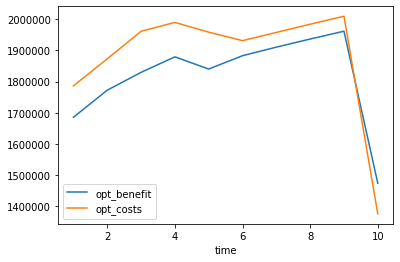

In [19]:
opt_df.groupby('time').sum()[['opt_benefit', 'opt_costs']].plot()